# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm
from utils import mape, mean_std_cross_val_scores
from xgboost import XGBClassifier, XGBRegressor

random.seed(0)

# 1. Tags and Data Preparation

In [2]:
tags = pd.read_excel("../data/tags/tags.xlsx")

In [3]:
tags_dict = {}
for i in range(len(tags)):
    tags_dict[f"{tags.loc[i, 'Tags']}"] = tags.loc[i, 'Definition']

In [4]:
df = pd.read_csv("../data/processed/economic_dataset.csv")

In [5]:
df

,DATE,A091RC1Q027SBEA,A939RX0Q048SBEA,BOGMBASE,CCSA,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GDPC1,GFDEGDQ188S,...,M2V,MEHOINUSA672N,PAYEMS,PCEC96,PPIACO,T10Y2Y,TOTRESNS,UNRATE,VIXCLS,SP500_full
0,1980-01-31,102.252,32377.0,156000.0,2781750.0,13.82,13.549202,-2.5839,7341.557,30.94982,...,1.869,56780.0,90800.0,11181.0,85.200,0.014615,45.2,6.3,23.347273,110.90
1,1980-02-29,102.252,32377.0,153900.0,2868500.0,14.13,13.549202,-2.5839,7341.557,30.94982,...,1.869,56780.0,90883.0,11181.0,86.900,0.014615,43.2,6.3,23.347273,115.30
2,1980-03-31,102.252,32377.0,155000.0,2881200.0,17.19,13.549202,-2.5839,7341.557,30.94982,...,1.869,56780.0,90994.0,11181.0,87.500,0.014615,43.1,6.3,23.347273,104.70
3,1980-04-30,107.264,31621.0,157900.0,3126500.0,17.61,13.549202,-2.5839,7190.289,31.37303,...,1.847,56780.0,90849.0,11181.0,87.800,0.014615,44.9,6.9,23.347273,103.00
4,1980-05-31,107.264,31621.0,157900.0,3544800.0,10.98,13.549202,-2.5839,7190.289,31.37303,...,1.847,56780.0,90420.0,11181.0,88.300,0.014615,44.0,7.5,23.347273,107.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2023-12-31,1025.796,67513.0,5827400.0,1802400.0,5.33,4.116338,-6.1903,22679.255,121.62069,...,1.350,74580.0,157304.0,15655.8,249.866,-0.437000,3492.0,3.7,12.718500,4685.05
528,2024-01-31,1059.235,67672.0,5843700.0,1782750.0,5.33,4.116338,-6.1903,22758.752,122.34717,...,1.361,74580.0,157560.0,15601.2,251.306,-0.264762,3507.0,3.7,13.388636,4804.49
529,2024-02-29,1059.235,67672.0,5896900.0,1797250.0,5.33,4.116338,-6.1903,22758.752,122.34717,...,1.361,74580.0,157796.0,15638.3,254.926,-0.336500,3567.7,3.9,13.980476,5011.96
530,2024-03-31,1059.235,67672.0,5883000.0,1801400.0,5.33,4.116338,-6.1903,22758.752,122.34717,...,1.361,74580.0,158106.0,15689.6,255.095,-0.379500,3543.1,3.8,13.787500,5170.57


In [6]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)

# 2. Train/Test Split

In [7]:
train_df = df.loc[df.index < "2023-01-01", :]
test_df = df.loc[df.index >= "2023-01-01", :]

In [8]:
train_df.head()

,A091RC1Q027SBEA,A939RX0Q048SBEA,BOGMBASE,CCSA,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GDPC1,GFDEGDQ188S,IMPGS,...,M2V,MEHOINUSA672N,PAYEMS,PCEC96,PPIACO,T10Y2Y,TOTRESNS,UNRATE,VIXCLS,SP500_full
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-31,102.252,32377.0,156000.0,2781750.0,13.82,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90800.0,11181.0,85.2,0.014615,45.2,6.3,23.347273,110.9
1980-02-29,102.252,32377.0,153900.0,2868500.0,14.13,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90883.0,11181.0,86.9,0.014615,43.2,6.3,23.347273,115.3
1980-03-31,102.252,32377.0,155000.0,2881200.0,17.19,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90994.0,11181.0,87.5,0.014615,43.1,6.3,23.347273,104.7
1980-04-30,107.264,31621.0,157900.0,3126500.0,17.61,13.549202,-2.5839,7190.289,31.37303,292.600,...,1.847,56780.0,90849.0,11181.0,87.8,0.014615,44.9,6.9,23.347273,103.0
1980-05-31,107.264,31621.0,157900.0,3544800.0,10.98,13.549202,-2.5839,7190.289,31.37303,292.600,...,1.847,56780.0,90420.0,11181.0,88.3,0.014615,44.0,7.5,23.347273,107.7


In [9]:
test_df.head()

,A091RC1Q027SBEA,A939RX0Q048SBEA,BOGMBASE,CCSA,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GDPC1,GFDEGDQ188S,IMPGS,...,M2V,MEHOINUSA672N,PAYEMS,PCEC96,PPIACO,T10Y2Y,TOTRESNS,UNRATE,VIXCLS,SP500_full
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-31,873.800,66096.0,5329000.0,1608500.0,4.33,4.116338,-6.1903,22112.329,117.32269,3890.491,...,1.271,74580.0,154773.0,15317.6,260.227,-0.676000,3029.9,3.4,20.169048,3960.66
2023-02-28,873.800,66096.0,5321600.0,1649250.0,4.57,4.116338,-6.1903,22112.329,117.32269,3890.491,...,1.271,74580.0,155060.0,15325.5,258.669,-0.786842,3021.8,3.6,20.120500,4079.68
2023-03-31,873.800,66096.0,5571500.0,1686500.0,4.65,4.116338,-6.1903,22112.329,117.32269,3890.491,...,1.271,74580.0,155206.0,15295.4,257.062,-0.639565,3258.4,3.5,21.644348,3968.56
2023-04-30,909.584,66357.0,5593100.0,1713200.0,4.83,4.116338,-6.1903,22225.350,119.47035,3767.851,...,1.301,74580.0,155484.0,15316.9,256.908,-0.556000,3269.5,3.4,17.817895,4121.47
2023-05-31,909.584,66357.0,5569600.0,1715250.0,5.06,4.116338,-6.1903,22225.350,119.47035,3767.851,...,1.301,74580.0,155787.0,15337.4,253.670,-0.558182,3235.6,3.7,17.636087,4146.17


In [10]:
X_train = train_df.drop(columns=["SP500_full"])
y_train = train_df["SP500_full"]

X_test = test_df.drop(columns=["SP500_full"])
y_test = test_df["SP500_full"]

# 3. Preparation of Preprocessors

In [11]:
preprocessor = StandardScaler()

# 4. Cross-Validation of ML Models

In [12]:
results = {}

In [13]:
mape_scorer = make_scorer(mape, greater_is_better=False)

In [14]:
def mean_std_cross_val_scores_timeseries(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    tscv = TimeSeriesSplit(n_splits=5)
    
    scores = []
    for train_idx, eval_idx in tscv.split(X_train, y_train):
        model.fit(X_train.iloc[train_idx, :], y_train[train_idx])
        scores.append(model.score(X_train.iloc[eval_idx, :], y_train[eval_idx]))
    
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## 4.1. Baseline Model

In [15]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [16]:
results["Dummy"] = mean_std_cross_val_scores_timeseries(
    pipe_dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring="neg_mean_squared_error",
)

In [17]:
pd.DataFrame(results)

,Dummy
0,-7.992 (+/- 4.537)


## 4.2. ML Models

In [18]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=random_state))
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [19]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [20]:
for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores_timeseries(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring="neg_mean_squared_error",
    )

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\johnw\miniconda3\envs\ls_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.416e+04, tolerance: 1.294e+04
  model = cd_fast.enet_coordinate_descent(
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


In [21]:
pd.DataFrame(results)

,Dummy,ridge,lass,random_forest,XGBoost,LightGBM,CatBoost
0,-7.992 (+/- 4.537),-378.494 (+/- 842.653),-489.317 (+/- 1089.844),-1.658 (+/- 1.361),-1.329 (+/- 1.063),-1.830 (+/- 2.015),-2.825 (+/- 1.821)


# 5. Evaluation of `Ridge` Model

In [22]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=123, ...))])

## 5.1. Comparison between Prediction and `y_test`

In [23]:
y_pred = pipe_xgb.predict(X_test)

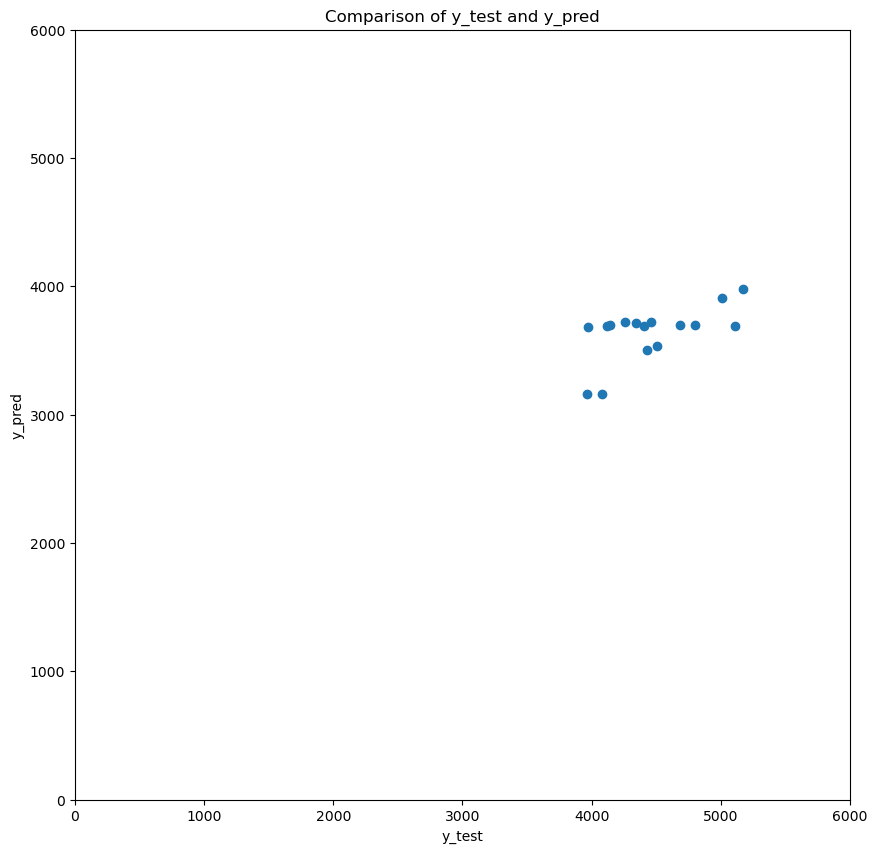

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 6000)
plt.ylim(0, 6000)
plt.title("Comparison of y_test and y_pred")
plt.show();

In [25]:
mape(y_test, y_pred)

18.120574612794346

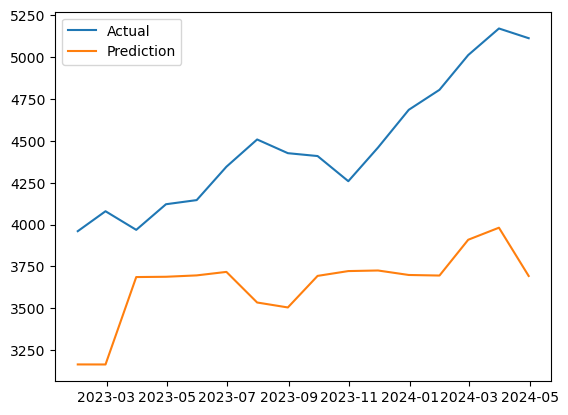

In [26]:
plt.figure()
plt.plot(X_test.index, y_test, label="Actual")
plt.plot(X_test.index, y_pred, label="Prediction")
plt.legend()
plt.show();